# Data Exploration

In [314]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import sklearn.metrics as skm

In [316]:
df = pd.read_csv("C:/Users/aceme/OneDrive/Documents/SIAM Simons Summer Opportunity/Datasets/WVS_Cross-National_Wave_7_csv_v6_0.csv")

C:\Users\aceme\AppData\Local\Temp\ipykernel_31268\3996359589.py:1: DtypeWarning: Columns (346,348,350,580,581,582,583) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("C:/Users/aceme/OneDrive/Documents/SIAM Simons Summer Opportunity/Datasets/WVS_Cross-National_Wave_7_csv_v6_0.csv")


In [317]:
df.head()
df.shape

(97220, 613)

In [318]:
# Column names
print(df.columns.values)

['version' 'doi' 'A_WAVE' 'A_YEAR' 'A_STUDY' 'B_COUNTRY' 'B_COUNTRY_ALPHA'
 'C_COW_NUM' 'C_COW_ALPHA' 'D_INTERVIEW' 'S007' 'J_INTDATE' 'FW_START'
 'FW_END' 'K_TIME_START' 'K_TIME_END' 'K_DURATION' 'Q_MODE' 'N_REGION_ISO'
 'N_REGION_WVS' 'N_REGION_NUTS2' 'N_REG_NUTS1' 'N_TOWN' 'G_TOWNSIZE'
 'G_TOWNSIZE2' 'H_SETTLEMENT' 'H_URBRURAL' 'I_PSU' 'O1_LONGITUDE'
 'O2_LATITUDE' 'L_INTERVIEWER_NUMBER' 'S_INTLANGUAGE' 'LNGE_ISO'
 'E_RESPINT' 'F_INTPRIVACY' 'E1_LITERACY' 'W_WEIGHT' 'S018' 'PWGHT' 'S025'
 'Q1' 'Q2' 'Q3' 'Q4' 'Q5' 'Q6' 'Q7' 'Q8' 'Q9' 'Q10' 'Q11' 'Q12' 'Q13'
 'Q14' 'Q15' 'Q16' 'Q17' 'Q18' 'Q19' 'Q20' 'Q21' 'Q22' 'Q23' 'Q24' 'Q25'
 'Q26' 'Q27' 'Q28' 'Q29' 'Q30' 'Q31' 'Q32' 'Q33' 'Q33_3' 'Q34' 'Q34_3'
 'Q35' 'Q35_3' 'Q36' 'Q37' 'Q38' 'Q39' 'Q40' 'Q41' 'Q42' 'Q43' 'Q44' 'Q45'
 'Q46' 'Q47' 'Q48' 'Q49' 'Q50' 'Q51' 'Q52' 'Q53' 'Q54' 'Q55' 'Q56' 'Q57'
 'Q58' 'Q59' 'Q60' 'Q61' 'Q62' 'Q63' 'Q64' 'Q65' 'Q66' 'Q67' 'Q68' 'Q69'
 'Q70' 'Q71' 'Q72' 'Q73' 'Q74' 'Q75' 'Q76' 'Q77' 'Q78' 'Q79' 'Q80' 'Q

In [319]:
# Column data types
df.dtypes.values

array([dtype('O'), dtype('O'), dtype('int64'), dtype('int64'),
       dtype('int64'), dtype('int64'), dtype('O'), dtype('int64'),
       dtype('O'), dtype('int64'), dtype('int64'), dtype('int64'),
       dtype('int64'), dtype('int64'), dtype('float64'), dtype('float64'),
       dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'),
       dtype('int64'), dtype('int64'), dtype('float64'), dtype('int64'),
       dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'),
       dtype('float64'), dtype('float64'), dtype('int64'), dtype('int64'),
       dtype('O'), dtype('int64'), dtype('int64'), dtype('int64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'),
       dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'),
       dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'),
       dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'),
       dtype('int64'), dty

# Data Cleaning

### Subsetting

In [322]:
# Subsetting a random sample of 500 observations 
df = df.sample(n=500)

# Find index of Q1-Q290 & label (Q46)
start_col_index = df.columns.get_loc('Q1')
end_col_index = df.columns.get_loc('v2xps_party')
label_index = df.columns.get_loc('Q46')

# Subsetting to only columns that are Core Questions to Contextual Questinos in WVS CodeBook
df = df.iloc[:,start_col_index:end_col_index]

In [328]:
# Column data types
df.dtypes.values

array([dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'),
       dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'),
       dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'),
       dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'),
       dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'),
       dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'),
       dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'),
       dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'),
       dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'),
       dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'),
       dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'),
       dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'),
       dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'),
       dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'),
      

### Changing classes

In [256]:
# Checking classes of Q1 & Q46
print(df.Q1.unique())
print(df.Q46.unique())

# Define the mapping for missing values
value_mapping = {
    -1: np.nan,
    -2: np.nan,
    -4: np.nan,
    -5: np.nan,
    -999.0: np.nan,
    -9999.0: np.nan
}

# Function to apply the mapping
def map_binary_values(x):
    return value_mapping.get(x, x)

# Apply the mapping only to the specified columns
df.iloc[:,start_col_index:end_col_index] = df.iloc[:,start_col_index:end_col_index].applymap(map_binary_values)

# Define the mapping for missing values
Q46_value_mapping = {
     1: 1,
     2: 1,
     3: 0,
     4: 0,
}

# Function to apply the mapping
def map_Q46_values(x):
    return Q46_value_mapping.get(x, x)

# Apply the mapping only to the specified column Q46
df.iloc[:,label_index] = df.iloc[:,label_index].map(map_Q46_values)

# Re-checking classes of Q1 & Q46
print(df.Q1.unique())
print(df.Q46.unique())

[ 1  2  3  4 -2 -1 -5]
[ 1  2  3  4 -1 -2 -5]


C:\Users\aceme\AppData\Local\Temp\ipykernel_31268\1976727575.py:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df.iloc[:,start_col_index:end_col_index] = df.iloc[:,start_col_index:end_col_index].applymap(map_binary_values)


[ 1.  2.  3.  4. nan]
[ 1.  0. nan]


### Dropping columns and NAs

In [258]:
# Dropping columns that confuse XGBoost
df = df.drop(columns=['X002_02B', 'V002A_01', 'V001A_01'])

# Drop rows where 'Q46' has NaN values
df = df.dropna(subset=['Q46'])

# Checking if it works
print(df['Q46'].isna().sum())

0


# Data Exploration

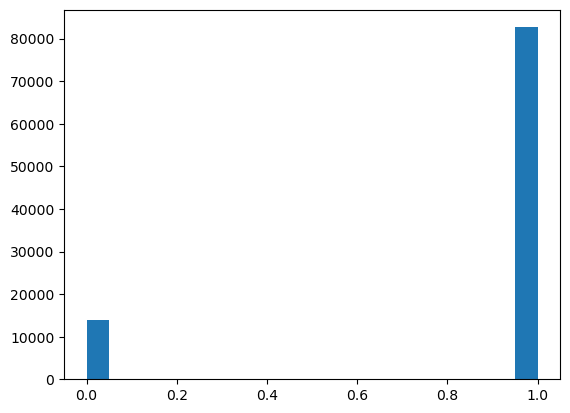

In [261]:
# Create a random number generator with a fixed seed for reproducibility
n_bins = 20

fig, axs = plt.subplots()

# We can set the number of bins with the *bins* keyword argument.
axs.hist(df['Q46'], bins=n_bins)

plt.show()

84.93
-9999.0


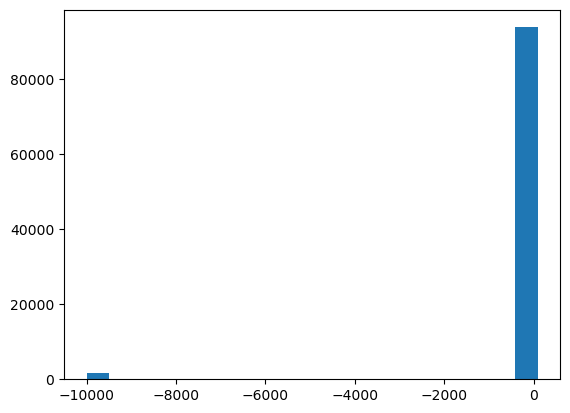

In [263]:
# Reviewing lifeexpect variable
print(df['lifeexpect'].max())
print(df['lifeexpect'].min())

# Histogram of Life Expectancy
n_bins = 20

fig, axs = plt.subplots()

# We can set the number of bins with the *bins* keyword argument.
axs.hist(df['lifeexpect'], bins=n_bins)

plt.show()

# Classifier: XGBoost

In [156]:
# First, put this prompt: "conda install -c conda-forge py-xgboost" in anaconda to download xgboost package
# install xgboost in jupyter
!pip install xgboost

In [273]:
##################################### Classifier: XGBOOST #####################################

# Find index of Q1-Q290 & label (Q46)
start_col_index = df.columns.get_loc('Q1')
end_col_index = df.columns.get_loc('Q290')
label_index = df.columns.get_loc('Q46')

# Split dataset into X_train and y_train
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,start_col_index:end_col_index], df.iloc[:,label_index], test_size=0.2, random_state=52)

# create model instance
# n_estimators: number of trees(estimators) the model uses --> the more used, the more accurate the model is
# max_depth: maximum depth of tree --> higher number makes model more complex, but too high can cause overfitting
# learning_rate: quantifies each tree's contribution to total prediction --> lower number takes longer, but can lead to better generalization
# objective: binary:logistic outputs probabilities. if classification is wanted, use binary:hinge
bst = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic', enable_categorical=True)

# fit model with the training data
bst.fit(X_train, y_train)

# make predictions for the test dataset
preds = bst.predict(X_test)

# print predictions
# print(preds)

# print model Accuracy (how often the classifier is correct)
print("Accuracy:",skm.accuracy_score(y_test, preds))

# Assign the accuracy directly to array
skm.f1_score(y_test, preds)  


Accuracy: 1.0


1.0